# Homework 1, DS-GA 1012, Spring 2019

## Due Feburary 13, 2019 at 2pm (ET)

Download the data zip `DS-GA1012-hw1-data.zip`. Complete the following questions in the notebook and submit your completed notebook on NYU Classes.

# 0. Set up

In [1]:
from collections import defaultdict
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        data = [r.split('\t')[1] for r in data_fh.readlines()]
    return data

## 1. Exploring effect of context size [30 pts]

We face many implicit and explicit design decisions in creating distributional word representations. For example, in lecture and in lab, we created word vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

__a__. Write `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. Feel free to modify the code used in lab [10 pts]

In [201]:
import time
from collections import defaultdict

def build_cooccurrence_matrix(data, max_vocab_size=20000, context_size =1):
    """ 
    
    args:
        - data: iterable where each item is a string sentence
        - max_vocab_size: maximum vocabulary size
        - context_size: window size
        
    returns:
        - coocur_mat: co-occurrence matrix as a numpy array
    """
    
    def get_token_frequencies():
        tok2freq = defaultdict(int)
        coocur_counts = defaultdict(lambda: defaultdict(int))

        for datum in data:
            tokens = datum.strip().split() # we'll use whitespace to tokenize
            for i, tok in enumerate(tokens):
                tok2freq[tok] += 1
                coocur_counts[tok][tok] += 1
                for c_size in range(1, context_size+1):
                    if i < len(tokens) - c_size:
                        coocur_counts[tok][tokens[i+c_size]] += 1
                        coocur_counts[tokens[i+c_size]][tok] += 1
#                     if i >= c_size:
#                         coocur_counts[tok][tokens[i-c_size]] += 1
#                         coocur_counts[tokens[i-c_size]][tok] += 1
        return tok2freq, coocur_counts
    
    def prune_vocabulary(tok2freq, max_vocab_size):
        """ Prune vocab by taking max_vocab_size most frequent words """
        tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
        tok_and_freqs.sort(key = lambda x: x[1], reverse=True) # sorts in-place
        tok2idx = {tok: idx for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size])}
        idx2tok = {idx: tok for tok, idx in tok2idx.items()}
        return tok2idx, idx2tok
    
    def _build_coocurrence_mat(idx2tok, coocur_counts):
        #mat = [[coocur_counts[idx2tok[i]][idx2tok[j]] for j in range(len(idx2tok))] for i in range(len(idx2tok))]
        vocab_size = len(idx2tok)
        mat = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]
        
#       mat = np.zeros(vocab_size, vocab_size) # create zero matrix with the vocab size  
        for i in range(vocab_size - 1):
            mat[i][i] = coocur_counts[idx2tok[i]][idx2tok[i]] # add the diagonal to the matrix
            for j in range(i+1, vocab_size):
                if coocur_counts[idx2tok[i]][idx2tok[j]]:
                    mat[i][j] = coocur_counts[idx2tok[i]][idx2tok[j]]
                    mat[j][i] = coocur_counts[idx2tok[i]][idx2tok[j]]
#             for m in range(i):
#                 if coocur_counts[idx2tok[m]][idx2tok[i]]:
#                     mat[m][i] = coocur_counts[idx2tok[m]][idx2tok[i]]
#                     mat[i][m] = coocur_counts[idx2tok[m]][idx2tok[i]]       
        return np.array(mat)
        
    print("Counting words...")
    start_time = time.time()
    tok2freq, coocur_counts = get_token_frequencies()
    print("\tFinished counting words in %.5f" % (time.time() - start_time))

    print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    print("\tFinished pruning vocabulary in %.5f" % (time.time() - start_time))
    
    print("Building co-occurrence matrix...")
    print("Max vocabulary is: %d" % (max_vocab_size))
    print("Context size is: %d" % (context_size))
    
    start_time = time.time()
    coocur_mat = _build_coocurrence_mat(idx2tok, coocur_counts)
    print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    print('\n')
    return coocur_mat, tok2idx, idx2tok

Use your implementation of `build_cooccurrence_matrix` to generate the co-occurence matrix from the sentences of [SST](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (file `datasetSentences.txt`) with `context_size=2` and `max_vocab_size=10000`. What is the co-occurrence count of the words "the" and "end"? 

In [4]:
data_file = 'datasetSentences.txt'
data = load_sst(data_file)
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size = 2)

i, j = tok2idx['end'], tok2idx['the']
print('The co-occurence score of words "the" and "end" is: ', int(mat[j][i]))

Counting words...
	Finished counting words in 0.52125
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
Max vocabulary is: 10000
Context size is: 2
	Finished building co-occurrence matrix in 25.48546


The co-occurence score of words "the" and "end" is:  98


__b__. Plot the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (see lab). [12 pts]

In [5]:
# load mturk data
mturk = 'MTURK-771.csv'
# mturk_data = pd.read_csv(mturk, header=None, names=["Word1", "Word2", "Similarity"])

def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

test_data, test_trgs = load_word_similarity_dataset(mturk)

In [7]:
# Normalize Matrix

def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
#     return u / np.sum(u)
    return u / np.linalg.norm(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])

In [8]:
# Similarity Metrics
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))

def length_norm(u):
    """L2 norm of the 1d np.array `u`. Returns a float."""
    return u / vector_length(u)

def cosine_similarity(u, v):        
    """Cosine similarity between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    
    return np.dot(u, v) / (vector_length(u) * vector_length(v))

Counting words...
	Finished counting words in 0.37704
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
Max vocabulary is: 10000
Context size is: 1
	Finished building co-occurrence matrix in 24.92384


Evaluated on 248 of 771 examples
Counting words...
	Finished counting words in 0.50737
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
Max vocabulary is: 10000
Context size is: 2
	Finished building co-occurrence matrix in 24.08728


Evaluated on 248 of 771 examples
Counting words...
	Finished counting words in 0.64099
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
Max vocabulary is: 10000
Context size is: 3
	Finished building co-occurrence matrix in 24.00874


Evaluated on 248 of 771 examples
Counting words...
	Finished counting words in 0.78439
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
Max vocabul

No handles with labels found to put in legend.


Evaluated on 248 of 771 examples


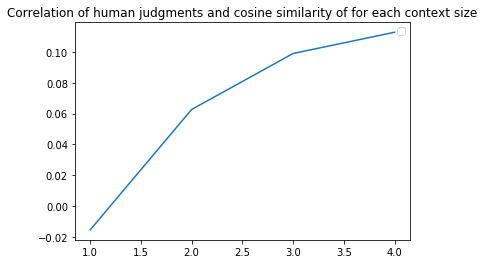

In [9]:
from scipy.stats import spearmanr

def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    
    cal_scores = []
    targs = []
    idx = 0
    
    for (word1, word2), targ in zip(word_pairs, targets): # use zip to map values between two dataset wit
        if word1 in tok2idx and word2 in tok2idx:
            score = cosine_similarity(mat[tok2idx[word1]], mat[tok2idx[word2]])
            cal_scores.append(score)
            targs.append(targ)
            idx +=1
    # get the Spearman correlation        
    corr, _ = spearmanr(targs, cal_scores, nan_policy = 'omit')
    print("Evaluated on %d of %d examples" % (idx, len(word_pairs)))
    return corr

    
context_size = [1, 2, 3, 4]
result = {}
spearman_corr = {}
output = []

for size in context_size:
    mat, tok2idx, _ = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size = size)
    result[size] = mat
    norm_mat = rowwise_norm_mat(mat)
    corr = evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)
    output.append(corr)

plt.plot(context_size, output)
plt.title('Correlation of human judgments and cosine similarity of for each context size')
plt.legend()

As it is shown on the graph, the correlation even goes to negative when context size is only 1.
The Spearman Correlation between human judgments and cosine similarity is increased as the context size increases.


In [22]:
pd.DataFrame({'context size': context_size, 'correlation score':output})

,context size,correlation score
0,1,-0.015468
1,2,0.062675
2,3,0.099013
3,4,0.112812


__c__. Briefly discuss the pros and cons of varying (i) the context size (ii) the vocabulary size (iii) using bigrams instead of unigrams (iv) using subword tokens instead of words. [8 pts]

(i) The Spearman Correlation between human judgments and cosine similarity is increased as the context size increases. As it is shown on the graph, the correlation even goes to negative when context size is only 1. When context size is larger, it may show more semantic information of the context, thus creates a more meaningful embedding for the words. 

pros: more semantic information between each words, possibly improve word embedding with more cooccurrence count

cons: increase calcualtion cost, may include unnecessary information between two unrelated words with huge context size like 100, they may even not in a same paragraph! 


(ii) The Spearman Correlation between human judgments and cosine similarity could be increased with a larger vocabulary size because more information is provided for each word with higher dimension. However, a larger vocabulary doesn't necessary improve the performance. A larger vocabulary or dimension of each word would also add sparsity and cost to the calculation. 

pros: possibly provide more information for each words, can match up more words in the document.

cons: increase calculation cost, introduce a higher dimension word embedding and higher sparsity as well.


(iii) Unigrams vs. Bigrams

Unigrams:

pros: unigrams is straight-forward to measure the cooccurrence count between two single words. Easy to interpret, calculate and manipulate in matrix. 

cons: does not contain much information of short phrase like : "American Express", or "Fedural Reserve" comparing with bigrams.


Bigrams:

pros: potentially contain more inforamtion than unigram especially for short phrase like "Star War"

cons: vocabulary size is much larger than unigrams with all combinations of two words. 

the cooccurrence matrix could be really sparsity with higher dimensions since it is harder for two bigrams to cooccur together. 


(iv) Subword tokens vs. Complete word

Subword tokens:

pros: By looking at subword token, like 'PowerShot'--> 'Power' and 'Shot' or 'AutoEncoder' --> 'Auto' and 'Encoder' understand more information within words.

cons: introduce higher vocabulary size comparing with single words. Higher dimension also cause sparsity problem. The meaning of word could be changed after subtokenize. Like 'Understand' --> 'Under' and 'Stand'


Complete word:

pros: smaller size of vocabulary size, can maintain information of the whole word.

cons: lack underlaying information of subword




## 2. Pointwise Mutual Information [20 pts]

In lecture, we introduced __pointwise mutual information__ (PMI), which addresses the issue of normalization removing information about absolute magnitudes of counts. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell.

__a__. Implement `pmi`, a function which takes in a co-occurence matrix and returns the matrix with PMI normalization applied. [15 pts]

In [141]:
# PMI using unigram and bigram sum

def pmi_1(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
        
    """  
    #total sum of unigram
    unigram_sum = mat.diagonal().sum() # frequency of single word
    
    #total sum of bigram (w1, w2)
    bi_mat = mat.copy()
    np.fill_diagonal(bi_mat, 0) #replace diagonal with zero for bigram calculation
    bigram_sum = (bi_mat.sum()/ 2)# here we assume its context size = 1
    
    pmi_mat = np.zeros_like(mat) 
    for i in range(mat.shape[0]):
        for j in range(i+1, mat.shape[0]):
            
                p_w1w2 = mat[i][j]/ bigram_sum
                p_w1 = mat[i][i] / unigram_sum
                p_w2 = mat[j][j] / unigram_sum
                if p_w1w2 == 0 or p_w1*p_w2 ==0 :
                    pmi_score = 0
                else:
                    pmi_score = np.log(p_w1w2 / (p_w1*p_w2))
                pmi_mat[i][j] = pmi_score
                pmi_mat[j][i] = pmi_score
    return pmi_mat

In [195]:
def pmi_2(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """    
#     np.fill_diagonal(mat, 0)
    total_sum = mat.sum()
    
    mat = mat/total_sum
    #row sum of matrix
    row_s = mat.sum(axis = 1)
    #column sum of matrix
    col_s = mat.sum(axis = 0)
    
    s1 = mat/col_s
    s2 = s1/row_s[:, np.newaxis]
    
    #change the 0 input as 1 so that log(1) = 0
    s2[s2 == 0] = 1
    
    return np.log(s2)

Apply PMI to the co-occurence matrix computed above with `context_size=1`. What is the PMI between the words "the" and "end"?

In [202]:
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size = 1)

Counting words...
	Finished counting words in 0.57446
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
Max vocabulary is: 10000
Context size is: 1
	Finished building co-occurrence matrix in 25.35439




In [193]:
i, j = tok2idx['end'], tok2idx['the']
pmi1 = pmi_1(mat)
print('Unigram sum method: The PMI normalization score of words "the" and "end" is: ', float(pmi1[j][i]))

Unigram sum method: The PMI normalization score of words "the" and "end" is:  2.0


In [196]:
pmi2 = pmi_2(mat)
print('Matrix sum method: The PMI normalization score of words "the" and "end" is: ', float(pmi2[j][i]))

/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Matrix sum method: The PMI normalization score of words "the" and "end" is:  2.1189804794420937


The second PMI method is straight-forward and directly works on the matrix itself. The PPMI is calculated based on this method. 

__b__. We also consider an extension of PMI, positive PMI (PPMI), that maps all negative PMI values to 0.0 ([Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization)). 
Write `ppmi`, which is the same as `pmi` except it applies PPMI instead of PMI (feel free to implement it as an option of `pmi`). What is the PMI of the words "the" and "start"? The PPMI? [5 pts]

In [203]:
def ppmi(mat):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - ppmi_mat: matrix of same shape with PMI applied
    """    
#     np.fill_diagonal(mat, 0)
    total_sum = mat.sum()
    
    mat = mat/total_sum
    #row sum of matrix
    row_s = mat.sum(axis = 1)
    #column sum of matrix
    col_s = mat.sum(axis = 0)
    
    s1 = mat/col_s
    s2 = s1/row_s[:, np.newaxis]
    #change the 0 input as 1 so that log(1) = 0
    s2[s2 == 0] = 1
    #If s2 is negative, manual change it to 1 so that log(s2) =0
    s2[s2 < 1] = 1
    return np.log(s2)

In [183]:
ppmi_1 = ppmi(mat)

/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


In [204]:
i, j = tok2idx['the'], tok2idx['start']
pmi = pmi_2(mat)
ppmi_1 = ppmi(mat)
print('The PMI normalization score of words "the" and "start" is: ', float(pmi[j][i]))
print('The PPMI normalization score of words "the" and "start" is: ', float(ppmi_1[j][i]))

The PMI normalization score of words "the" and "start" is:  0.2921512782120165
The PPMI normalization score of words "the" and "start" is:  0.2921512782120165


The PMI and PPMI scores are same probably because there is not negative element in current matrix.

## 3. Analyzing PMI [25 pts]

__a__. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `ppmi`. (i) What is the value obtained for cell `[0,0]`, and (ii) give a brief description for what is likely problematic about this value. [10 pts]

In [205]:
mat2 = np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])
ppmi(mat2)

array([[1.60893804, 0.        , 0.        ],
       [0.        , 0.        , 0.28788209],
       [0.22289371, 0.51107566, 0.        ]])

i. The value of cell [0,0] is 1.60893804

ii. The value is nomalized higher than its previous value (from 1 to 1.6) because of other large elements. After normalization, large value like 1000 is normalized to 0. Thus, PMI tends to normalize infrequent elements larger. 


__b__. Give a suggestion for dealing with the problematic value and explain why it deals with this. Demonstrate your suggestion empirically [10 pts]

One possible solutioin is to use the similar idea of Laplace smoothing. Adding a small constant m to each count before the PMI normalization process. For example, after adding 3 to 1 and 1000, the relative ratio between 1000 and 1 which is 1000 (1000/1) is now changed to 250.75 (1003/4). The larger value is indirectly discounted by adding constant, with a larger constant m, the discount effect is stronger for large values. 


__c__. Consider starting with a word-word co-occurence matrix and applied PMI to this matrix. (i) Which of the following describe the resulting vectors: sparse, dense, high-dimensional, low-dimensional (ii) If you wanted the opposite style of representation, what could you do? [5 pts]


In [208]:
pmi2

array([[ 2.69843176,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.95499042],
       [ 0.        ,  2.02258584, -0.88402636, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.88402636,  2.16160906, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 10.41403647,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        10.41403647,  0.        ],
       [ 1.95499042,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

i. The resulting matrix has a high sparsity with many zero values and it is also high in dimensions. One possible solution is to use PCA method to reduce the dimension and sparsity of the matrix. 

ii. Since the resulting co-occurence matrix is symmetric already, it is good to perform PCA anlaysis and choose the top K features. 

## 4. Word Analogy Evaluation [25 pts]

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

__a__. Implement the function `analogy_completion`. [9 pts]

In [72]:
def analogy_completion(a, b, c, mat):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    return closest word index and minimum distance
    """
    # calculate the vector
    
    v = (mat[b]-mat[a]) + mat[c]
    min_distance = float('inf')
    closest_vc = None
    for u in mat:
        if u not in (a, b, c): # filter same words that are used in analogy
            distance = 1- cosine_similarity(mat[u], v)
            if distance < min_distance:
                min_distance = distance
                closest_vc =  u    
    return closest_vc, min_distance


In [73]:
"China" not in ("Beijing", "good")

True

__b__. Our simple word embeddings likely won't perform well on this task. Let's instead look at some high quality pretrained word embeddings. Write code to load 300-dimensional [GloVe word embeddings](http://nlp.stanford.edu/data/glove.840B.300d.zip) trained on 840B tokens. Each line of the file is formatted as a word followed by 300 floats that make up its corresponding word embedding (all space delimited). The entries of GloVe word embeddings are not counts, but instead are learned via machine learning. Use your `analogy_completion` code to complete the following analogies using the GloVe word embeddings. [6 pts]

- "Beijing" is to "China" as "Paris" is to ?
- "gold" is to "first" as "silver" is to ?
- "Italian" is to "mozzarella" as "American" is to ?
- "research" is to "fun" as "engineering" is to ?

In [74]:
def load_glove(glove_file, n_vecs=20000):
    """ """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if i >= n_vecs:
                break
    return tok2vec

In [38]:
glove_file = "glove.840B.300d.txt"
glove_vecs = load_glove(glove_file, n_vecs=50000)

In [75]:
def test_analogy(word1, word2, word3, mat):
    output, distance = analogy_completion(word1, word2, word3, mat)
    print('"%s" is to "%s" as %s" to "%s"' % (word1, word2, word3, output))
    print('The minimum distance is: ', distance)
    return output, distance

In [76]:
test_analogy('Beijing', 'China', 'Paris', glove_vecs)

"Beijing" is to "China" as Paris" to "France"
The minimum distance is:  0.27706330530641043


('France', 0.27706330530641043)

In [77]:
test_analogy('gold', 'first', 'silver', glove_vecs)

"gold" is to "first" as silver" to "second"
The minimum distance is:  0.3024389409663598


('second', 0.3024389409663598)

In [78]:
test_analogy('Italian', "mozzarella", "American", glove_vecs)

"Italian" is to "mozzarella" as American" to "cheddar"
The minimum distance is:  0.4171742770336405


('cheddar', 0.4171742770336405)

In [79]:
test_analogy("research", "fun", "engineering", glove_vecs)

"research" is to "fun" as engineering" to "awesome"
The minimum distance is:  0.5027277614731709


('awesome', 0.5027277614731709)

c. Let's get a more quantitative, aggregate sense of the quality of GloVe embeddings. Load the analogies from `gram6-nationality-adjective.txt` and evaluate GloVe embeddings. Report the mean reciprocal rank of the correct answer (the last word on each line) for each analogy. [10 pts]

__Solution__

In [87]:
def load_analogy_file(test_file):
    input_words = []
    true_words = []
    with open(test_file, 'r') as analogy_file:
        rows = [line.rstrip('\n') for line in analogy_file]
        for row in rows:
            words = row.split(' ')
            input_words.append(words[:3])
            true_words.append(words[-1])
    return input_words, true_words

In [104]:
def analogy_completion_list(a, b, c, mat):
    """Compute ? in 
    a is to b as c is to ? 
    
    return list of top 15 possible words for analogy 
    
    I make an assumption that the most true words are within the top 15 prediction words
    """
    # calculate the vector
    
    v = (mat[b]-mat[a]) + mat[c]
    
    distance_list = []
    words_list = []
    closest_vc = None
    for u in mat:
        if u not in (a, b, c):
            distance = 1- cosine_similarity(mat[u], v)
            distance_list.append(distance)
            words_list.append(u)   
    result = sorted(zip( distance_list, words_list))
    return [line[1] for line in result]

analogy_completion_list('Beijing', 'China', 'Paris', glove_vecs)


['France',
 'French',
 'Europe',
 'Pierre',
 'Le',
 'Jean',
 'paris',
 'FRANCE',
 'PARIS',
 'france',
 'Italy',
 'Belgium',
 'du',
 'Luxembourg',
 'Provence']

In [133]:
# analogy_completion_list('Beijing', 'China', 'Paris', glove_vecs)

In [132]:
# test_list.index('FRANCE')

In [131]:
# 'FRANCH' in test_list

In [137]:
def analogy_completion_list(a, b, c, mat):
    """Compute ? in 
    a is to b as c is to ? 
    
    return list of possible words for analogy prediction
 
    
    """
    # calculate the vector
    v = (mat[b]-mat[a]) + mat[c]
    
    distance_list = []
    words_list = []
    
    for u in mat:
        if u not in (a, b, c):
            distance = 1- cosine_similarity(mat[u], v)
            distance_list.append(distance)
            words_list.append(u)  

    result = sorted(zip( distance_list, words_list)) # return all closest prediction
#   result = sorted(zip( distance_list, words_list))[:15]# return the top 15 closest prediction
    return [line[1] for line in result]


def mean_reciprocal_rank(true_words, predict_words_list):
    
    '''
    Take list of true words and predict_words_list
    
    Return mean_reciprocal_rank and the accuracy of the prediction
    
    '''
    rr = 0
    correct = 0
    for i in range(len(true_words)):
        true_word = true_words[i]
        predict_words = predict_words_list[i]
        if true_word in predict_words:
            pos_idx = predict_words.index(true_word)
            if pos_idx == 0:
                #Calcualte the correctness of the first prediction
                correct +=1  
            #reciprocal_rank
            rr += 1/(pos_idx+1) 
            
    mrr = rr/len(true_words) 
    return mrr, correct


def analogy_evaluation(glove_vecs, test_file, verbose=False):
    """Basic analogies evaluation for a file `src_filename `
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    
    input_words, true_words = load_analogy_file(test_file)
    predict_words_list = []
    existing_true_words = []
    
    for i in range(len(input_words)):
        a,b,c = input_words[i]
        if a in glove_vecs and b in glove_vecs and c in glove_vecs and true_words[i] in glove_vecs: # ignore words not in glove
            predict_words_list.append(analogy_completion_list(a, b, c, glove_vecs))
            existing_true_words.append(true_words[i]) #found the words in glove_vecs
            
    mrr, correct = mean_reciprocal_rank(existing_true_words, predict_words_list)
    
    return mrr, (correct/len(existing_true_words))

In [130]:
# get top 15 predictions for each analogy and ignore all 4 words not in glove
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.9526251526251527, 0.9358974358974359)

In [135]:
# get all predctions for each analogy and allow true words not in glove
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.7995877163039019, 0.7849462365591398)

In [138]:
# get all predictions for each analogy and ignore all 4 words not in glove
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.953354584823883, 0.9358974358974359)

Vocabulary size = 20000 in glove embedding is used for this case:

MRR that ignores words(including true word) in glove embedding is around 0.95 with accuracy of 0.93

MRR that allows true word not in glove embedding is around 0.8 with accuracy of 0.78, it is possible that if the vocabulary size of glove embedding increase, MRR would be higher in this case.

In [16]:
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.9391509433962264, defaultdict(int, {True: 97, False: 9}))